In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import torch
from matplotlib.ticker import MaxNLocator
from tqdm import tqdm

import os
import sys

# Set up path to import from src
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.append(src_path)

# Import pokie from pokie.py
from pokie import pokie, pokie_bootstrap, get_device, pokie_with_convergence_estimate, pokie_test

# Num Runs

In [2]:
curr_num_runs = 100

# Data Set Up

In [3]:
# load in the .pt files in Downloads/samples
truth = torch.load('/Users/sammysharief/Downloads/samples/true.pt', map_location=torch.device('cpu'))
posterior4 = torch.load('/Users/sammysharief/Downloads/samples/posterior4.pt', map_location=torch.device('cpu'))
posterior3 = torch.load('/Users/sammysharief/Downloads/samples/posterior3.pt', map_location=torch.device('cpu'))
posterior2 = torch.load('/Users/sammysharief/Downloads/samples/posterior2.pt', map_location=torch.device('cpu'))
posterior1 = torch.load('/Users/sammysharief/Downloads/samples/posterior1.pt', map_location=torch.device('cpu'))
posterior0 = torch.load('/Users/sammysharief/Downloads/samples/posterior0.pt', map_location=torch.device('cpu'))
observations = torch.load('/Users/sammysharief/Downloads/samples/observations.pt', map_location=torch.device('cpu'))

# Load Data and Normalize

In [4]:
x_obs = truth
y_obs = observations
post_samp0 = posterior0
post_samp1 = posterior1
post_samp2 = posterior2
post_samp3 = posterior3

# Find max and min for truth, posterior4, posterior3, posterior2, posterior1, posterior0, observations
truth_max = torch.max(truth)
truth_min = torch.min(truth)

posterior4_max = torch.max(posterior4)
posterior4_min = torch.min(posterior4)

posterior3_max = torch.max(posterior3)
posterior3_min = torch.min(posterior3)

posterior2_max = torch.max(posterior2)
posterior2_min = torch.min(posterior2)

posterior1_max = torch.max(posterior1)
posterior1_min = torch.min(posterior1)

posterior0_max = torch.max(posterior0)
posterior0_min = torch.min(posterior0)

observations_max = torch.max(observations)
observations_min = torch.min(observations)

# Identify the max and min of all the data
max_data = truth_max
min_data = truth_min

# Normalize the data based on max_data and min_data
truth = (truth - min_data) / (max_data - min_data)
posterior4 = (posterior4 - min_data) / (max_data - min_data + 1e-10)
posterior3 = (posterior3 - min_data) / (max_data - min_data + 1e-10)
posterior2 = (posterior2 - min_data) / (max_data - min_data + 1e-10)
posterior1 = (posterior1 - min_data) / (max_data - min_data + 1e-10)
posterior0 = (posterior0 - min_data) / (max_data - min_data + 1e-10)

print(f'Truth max: {torch.max(truth)} and min: {torch.min(truth)}')
print(f'Posterior4 max: {torch.max(posterior4)} and min: {torch.min(posterior4)}')
print(f'Posterior3 max: {torch.max(posterior3)} and min: {torch.min(posterior3)}')
print(f'Posterior2 max: {torch.max(posterior2)} and min: {torch.min(posterior2)}')
print(f'Posterior1 max: {torch.max(posterior1)} and min: {torch.min(posterior1)}')
print(f'Posterior0 max: {torch.max(posterior0)} and min: {torch.min(posterior0)}')

# Reshape the Truth 
truth = truth.reshape(16, 64 * 64 * 3)

# Reshape all posteriors from 16,3,64,64 to 16,64,3x64x64
posterior3_reshape = posterior3.reshape(16, 64, 64 * 64 * 3)
posterior2_reshape = posterior2.reshape(16, 64, 64 * 64 * 3)
posterior1_reshape = posterior1.reshape(16, 64, 64 * 64 * 3)
posterior0_reshape = posterior0.reshape(16, 64, 64 * 64 * 3)

# Make truth, posterior0, posterior1, posterior2, posterior3, posterior4, observations into numpy arrays
truth = truth.numpy()
posterior3_reshape = posterior3_reshape.numpy()
posterior2_reshape = posterior2_reshape.numpy()
posterior1_reshape = posterior1_reshape.numpy()
posterior0_reshape = posterior0_reshape.numpy()

Truth max: 1.0 and min: 0.0
Posterior4 max: 0.8527698516845703 and min: -0.010756193660199642
Posterior3 max: 0.771514356136322 and min: -0.006224202457815409
Posterior2 max: 0.6889628767967224 and min: -0.0005897657829336822
Posterior1 max: 1.0044115781784058 and min: -0.013637484982609749
Posterior0 max: 1.038083791732788 and min: -2.8896414733026177e-05


In [5]:
# # Identify your device (CUDA > MPS > CPU)
# device = get_device()
# print("Using device:", device)

# posterior = [posterior0_reshape, posterior1_reshape, posterior2_reshape, posterior3_reshape]

# # Convert to torch Tensors on the chosen device
# posterior   = torch.tensor(posterior, dtype=torch.float32, device=device)
# truth = torch.tensor(truth,   dtype=torch.float32, device=device)

# results, calibrated, n_over_N_vals = pokie(truth, posterior, num_runs=curr_num_runs)

# # Convert results, calibrated, n_over_N_vals back to numpy arrays
# results = results.cpu().numpy()
# calibrated = calibrated.cpu().numpy()
# n_over_N_vals = n_over_N_vals.cpu().numpy()

# l_values = np.linspace(0, len(results) - 1, len(results))
# l_values = np.array(l_values)

# print('\Modes:', l_values)
# print('Results:', results)
# print('Calibrated:', calibrated)

In [6]:
list_of_distance_metrics = ['canberra', 'braycurtis', 'seuclidean', 'euclidean', 'cosine', 'correlation', 'cityblock', 'chebyshev']
# list_of_distance_metrics = []

# Assume you have a function pokie(gt_norm, posterior_norm, num_runs)
# that returns (raw_probs, calibrated_probs, n_over_N_vals).
device = get_device()
print("Using device:", device)

posterior = [posterior0_reshape, posterior1_reshape, posterior2_reshape, posterior3_reshape]

l_values = np.linspace(0, len(posterior) - 1, len(posterior))
l_values = np.array(l_values)

# Convert to torch Tensors on the chosen device
posterior   = torch.tensor(posterior, dtype=torch.float32, device=device)
truth = torch.tensor(truth,   dtype=torch.float32, device=device)

Using device: mps


/var/folders/jv/k_v96nss5g52chcq2phrbl240000gn/T/ipykernel_51104/3708249877.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  posterior   = torch.tensor(posterior, dtype=torch.float32, device=device)


In [7]:
# Define a text file to save the results
results_file = f"Pokie_Result_Lensed_Images_Curr_Num_Runs_{curr_num_runs}.txt"

Pokie MC runs: 100%|██████████| 100/100 [00:13<00:00,  7.19it/s]


Distance Metric: canberra
Lens Model: [0. 1. 2. 3.]
Raw Pokie: [0.25020787 0.24756362 0.25409448 0.24813403]
Calibrated Pokie: [0.505459   0.5001172  0.51331055 0.5012695 ]


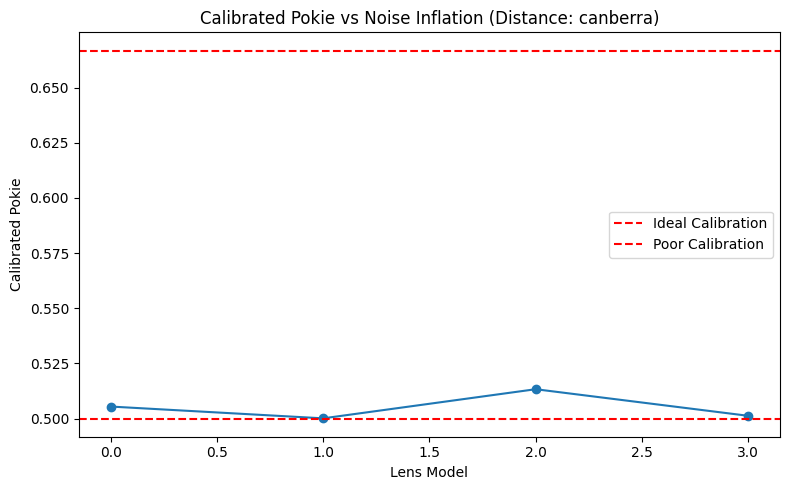

Pokie MC runs: 100%|██████████| 100/100 [00:11<00:00,  9.00it/s]


Distance Metric: braycurtis
Lens Model: [0. 1. 2. 3.]
Raw Pokie: [0.2495597  0.24894208 0.24570437 0.2557939 ]
Calibrated Pokie: [0.50507814 0.5038281  0.49727538 0.5176953 ]


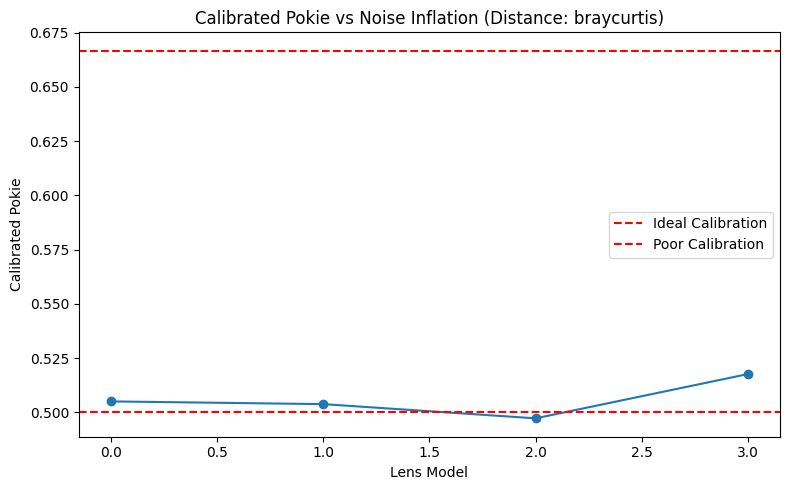

Pokie MC runs: 100%|██████████| 100/100 [00:13<00:00,  7.22it/s]


Distance Metric: seuclidean
Lens Model: [0. 1. 2. 3.]
Raw Pokie: [0.24357724 0.2527855  0.24886559 0.25477162]
Calibrated Pokie: [0.500625   0.5195508  0.51149416 0.5236328 ]


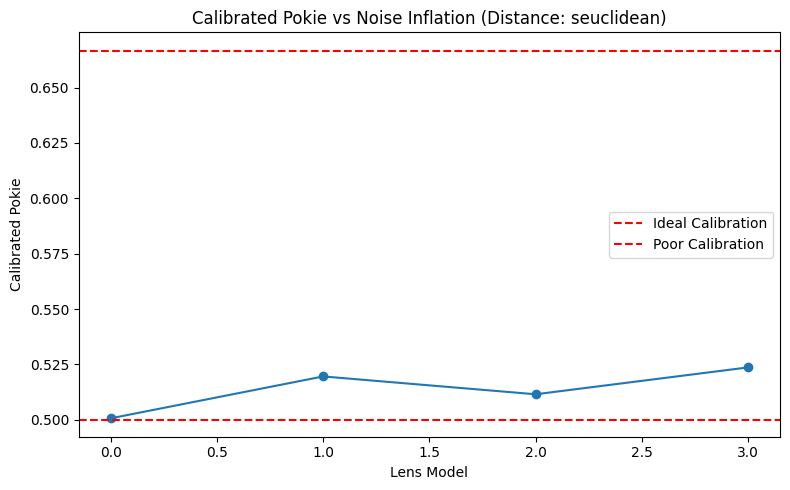

Pokie MC runs: 100%|██████████| 100/100 [00:01<00:00, 74.42it/s]


Distance Metric: euclidean
Lens Model: [0. 1. 2. 3.]
Raw Pokie: [0.2870848  0.2539205  0.23823854 0.22075617]
Calibrated Pokie: [0.644668   0.5701953  0.5349805  0.49572265]


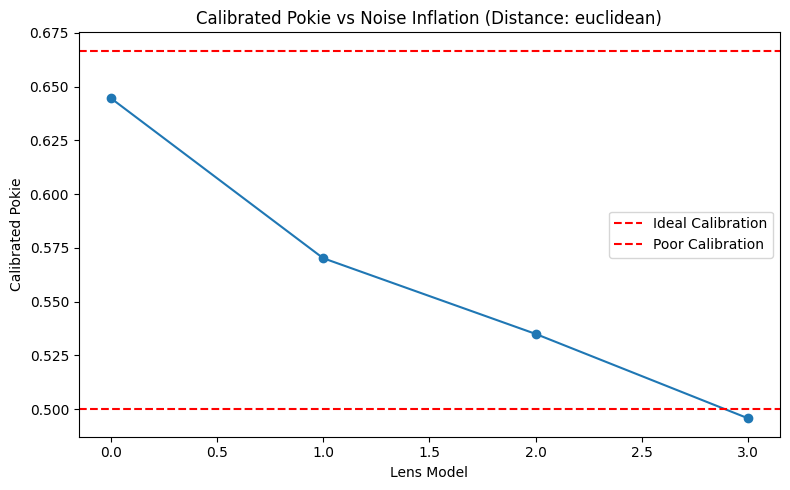

Pokie MC runs: 100%|██████████| 100/100 [00:20<00:00,  4.77it/s]

Distance Metric: cosine
Lens Model: [0. 1. 2. 3.]
Raw Pokie: [0.25306183 0.24737988 0.25079772 0.24876054]
Calibrated Pokie: [0.51192385 0.5004297  0.50734377 0.50322264]


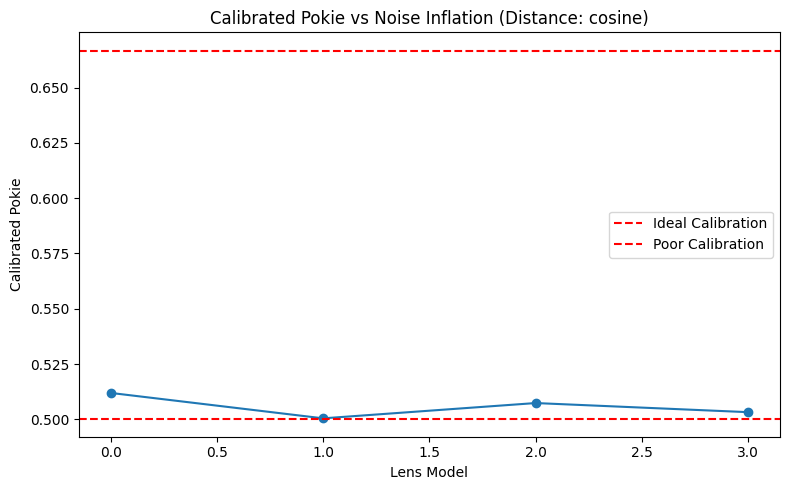

Pokie MC runs: 100%|██████████| 100/100 [00:27<00:00,  3.59it/s]

Distance Metric: correlation
Lens Model: [0. 1. 2. 3.]
Raw Pokie: [0.2531811  0.2530843  0.24710687 0.2466277 ]
Calibrated Pokie: [0.5108398  0.51064456 0.49858397 0.4976172 ]


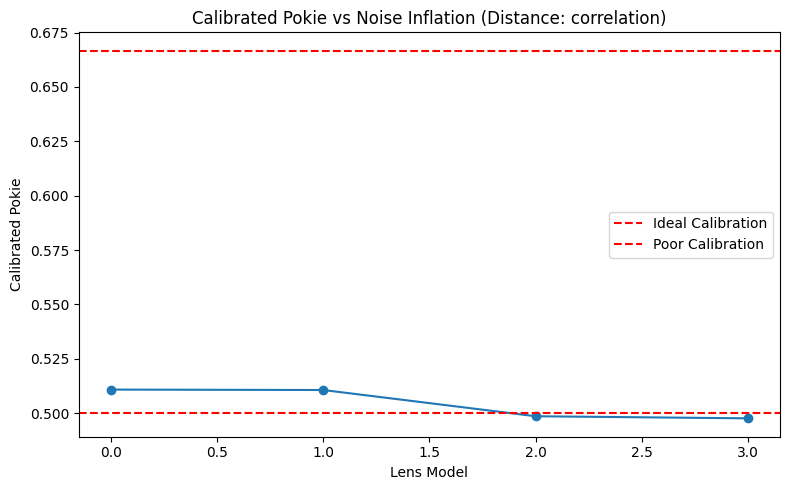

Pokie MC runs: 100%|██████████| 100/100 [00:10<00:00,  9.39it/s]

Distance Metric: cityblock
Lens Model: [0. 1. 2. 3.]
Raw Pokie: [0.24633095 0.25123104 0.25299624 0.24944177]
Calibrated Pokie: [0.4987793  0.50870115 0.5122754  0.50507814]


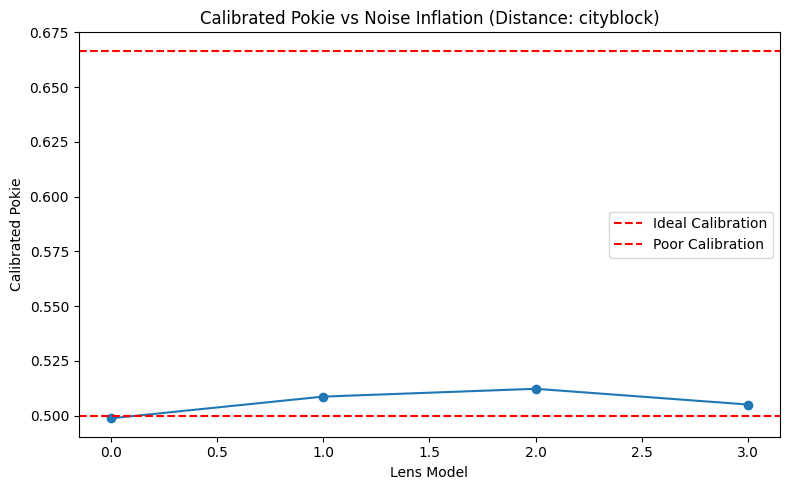

Pokie MC runs: 100%|██████████| 100/100 [00:10<00:00,  9.40it/s]

Distance Metric: chebyshev
Lens Model: [0. 1. 2. 3.]
Raw Pokie: [0.25404283 0.24449036 0.25552663 0.2459402 ]
Calibrated Pokie: [0.51163083 0.49239257 0.5146191  0.4953125 ]


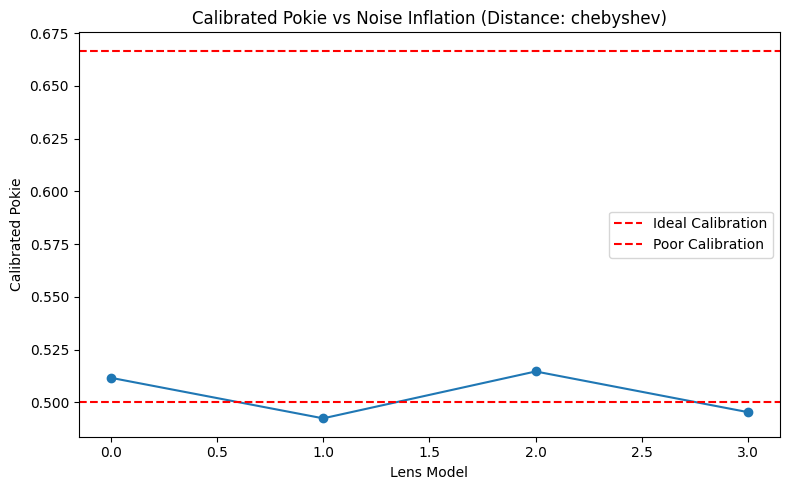

In [8]:
# -------------------------------
# 4. Pokie Evaluation
# -------------------------------
# Open the file in write mode
with open(results_file, "a") as f:
    for distance_metric in list_of_distance_metrics:
        try:
            results, calibrated, n_over_N_vals = pokie_test(
                truth, posterior, num_runs=curr_num_runs, distance_metric=distance_metric
            )
        except Exception as e:
            print(f"Error with distance metric '{distance_metric}': {e}")
            continue

        # Convert results, calibrated, n_over_N_vals back to numpy arrays
        results = results.cpu().numpy()
        calibrated = calibrated.cpu().numpy()
        n_over_N_vals = n_over_N_vals.cpu().numpy()
        print(f"Distance Metric: {distance_metric}")
        print("Lens Model:", l_values)
        print("Raw Pokie:", results)
        print("Calibrated Pokie:", calibrated)

        # Write the results as follows --> Distance Metric | Calibrated Pokie
        for noise_level, cal_pokie in zip(l_values, calibrated):
            f.write(f"\n{distance_metric} | {noise_level} | {cal_pokie}\n")

        # -------------------------------
        # 5. Plotting
        # -------------------------------
        plt.figure(figsize=(8,5))
        plt.plot(l_values, calibrated, marker='o')
        plt.xlabel('Lens Model')
        plt.ylabel('Calibrated Pokie')
        plt.title('Calibrated Pokie vs Noise Inflation (Distance: {})'.format(distance_metric))
        plt.axhline(y=2/3, color='r', linestyle='--', label='Ideal Calibration')
        plt.axhline(y=1/2, color='r', linestyle='--', label='Poor Calibration')
        plt.legend()
        plt.tight_layout()
        plt.show()

{'canberra': {0.0: 0.470703125, 1.0: 0.595703125, 2.0: 0.4619140625, 3.0: 0.376953125}, 'braycurtis': {0.0: 0.501953125, 1.0: 0.5087890625, 2.0: 0.4453125, 3.0: 0.5634765625}, 'seuclidean': {0.0: 0.5791015625, 1.0: 0.4892578125, 2.0: 0.578125, 3.0: 0.572265625}, 'euclidean': {0.0: 0.63671875, 1.0: 0.5537109375, 2.0: 0.4873046875, 3.0: 0.4482421875}, 'cosine': {0.0: 0.3984375, 1.0: 0.5908203125, 2.0: 0.51171875, 3.0: 0.498046875}, 'correlation': {0.0: 0.57421875, 1.0: 0.474609375, 2.0: 0.4951171875, 3.0: 0.6181640625}, 'cityblock': {0.0: 0.419921875, 1.0: 0.548828125, 2.0: 0.6376953125, 3.0: 0.3935546875}, 'chebyshev': {0.0: 0.5146484375, 1.0: 0.37890625, 2.0: 0.431640625, 3.0: 0.6005859375}}
dict_keys(['canberra', 'braycurtis', 'seuclidean', 'euclidean', 'cosine', 'correlation', 'cityblock', 'chebyshev'])


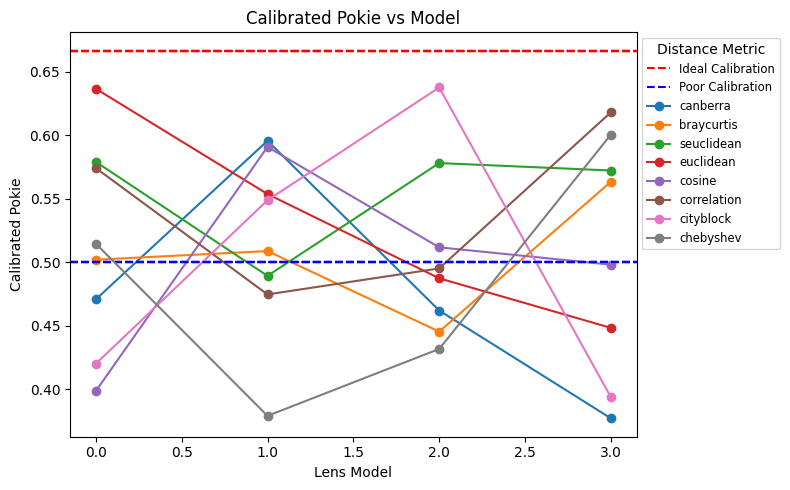

In [12]:
# Load in the data for all the distance metrics
data = {}
results_file = '/Users/sammysharief/Downloads/Pokie/notebook/Distance_Exp/Pokie_Result_Lensed_Images_Curr_Num_Runs_1.txt'
# Read the results file and store the data
with open(results_file, "r") as f:
    for line in f:
        if line.strip():  # Skip empty lines
            parts = line.strip().split('|')
            if len(parts) == 3:
                distance_metric = parts[0].strip()
                noise_level = float(parts[1].strip())
                calibrated_pokie = float(parts[2].strip())
                
                if distance_metric not in data:
                    data[distance_metric] = {}
                data[distance_metric][noise_level] = calibrated_pokie

print(data)
print(data.keys())
plt.figure(figsize=(8, 5))
# Plot the data for each key in data
for distance_metric, noise_data in data.items():
    noise_levels = sorted(noise_data.keys())
    calibrated_values = [noise_data[nl] for nl in noise_levels]

    if distance_metric == 'canberra':
        plt.axhline(y=2/3, color='r', linestyle='--', label='Ideal Calibration')
        plt.axhline(y=1/2, color='b', linestyle='--', label='Poor Calibration')
    else:
        plt.axhline(y=2/3, color='r', linestyle='--')
        plt.axhline(y=1/2, color='b', linestyle='--')
    
    
    plt.plot(noise_levels, calibrated_values, marker='o', label=distance_metric)
    plt.xlabel('Lens Model')
    plt.ylabel('Calibrated Pokie')
    plt.title(f'Calibrated Pokie vs Model')
    
# Put Legend outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small', title='Distance Metric')
plt.tight_layout()
plt.savefig(f'{project_root}/Plots/Different_Distance_Metrics/Pokie_Lensed_Images_Different_Distance_Metrics_Curr_Num_Runs_1.pdf')
plt.show()
    

{'canberra': {0.0: 0.5101171731948853, 1.0: 0.5234179496765137, 2.0: 0.5140625238418579, 3.0: 0.4954492151737213}, 'braycurtis': {0.0: 0.5040038824081421, 1.0: 0.4923046827316284, 2.0: 0.5256640911102295, 3.0: 0.5102734565734863}, 'seuclidean': {0.0: 0.5077539086341858, 1.0: 0.5180859565734863, 2.0: 0.5221874713897705, 3.0: 0.4983593821525574}, 'euclidean': {0.0: 0.6469531059265137, 1.0: 0.5706250071525574, 2.0: 0.53125, 3.0: 0.5078710913658142}, 'cosine': {0.0: 0.4944726526737213, 1.0: 0.5140429735183716, 2.0: 0.5092577934265137, 3.0: 0.49748048186302185}, 'correlation': {0.0: 0.49781250953674316, 1.0: 0.5192187428474426, 2.0: 0.5036523342132568, 3.0: 0.49365234375}, 'cityblock': {0.0: 0.5003515481948853, 1.0: 0.5171484351158142, 2.0: 0.50390625, 3.0: 0.5058984160423279}, 'chebyshev': {0.0: 0.515917956829071, 1.0: 0.5023242235183716, 2.0: 0.4911132752895355, 3.0: 0.5249804854393005}}
dict_keys(['canberra', 'braycurtis', 'seuclidean', 'euclidean', 'cosine', 'correlation', 'cityblock', 

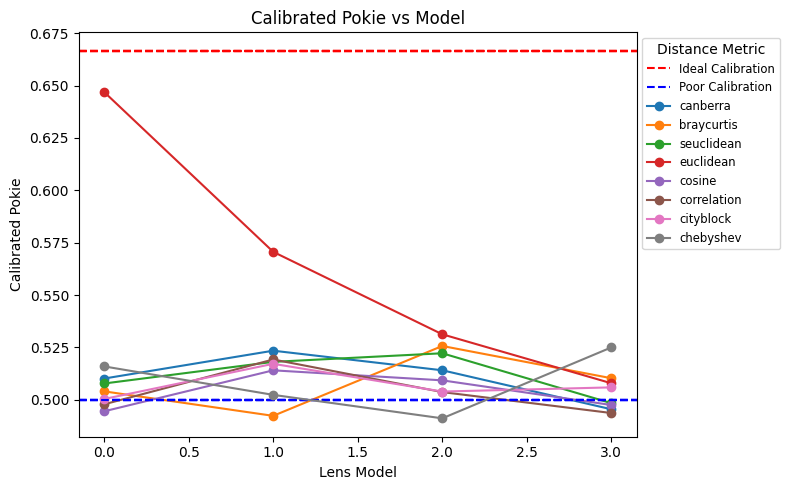

In [13]:
# Load in the data for all the distance metrics
data = {}
results_file = '/Users/sammysharief/Downloads/Pokie/notebook/Distance_Exp/Pokie_Result_Lensed_Images_Curr_Num_Runs_50.txt'
# Read the results file and store the data
with open(results_file, "r") as f:
    for line in f:
        if line.strip():  # Skip empty lines
            parts = line.strip().split('|')
            if len(parts) == 3:
                distance_metric = parts[0].strip()
                noise_level = float(parts[1].strip())
                calibrated_pokie = float(parts[2].strip())
                
                if distance_metric not in data:
                    data[distance_metric] = {}
                data[distance_metric][noise_level] = calibrated_pokie

print(data)
print(data.keys())
plt.figure(figsize=(8, 5))
# Plot the data for each key in data
for distance_metric, noise_data in data.items():
    noise_levels = sorted(noise_data.keys())
    calibrated_values = [noise_data[nl] for nl in noise_levels]

    if distance_metric == 'canberra':
        plt.axhline(y=2/3, color='r', linestyle='--', label='Ideal Calibration')
        plt.axhline(y=1/2, color='b', linestyle='--', label='Poor Calibration')
    else:
        plt.axhline(y=2/3, color='r', linestyle='--')
        plt.axhline(y=1/2, color='b', linestyle='--')
    
    
    plt.plot(noise_levels, calibrated_values, marker='o', label=distance_metric)
    plt.xlabel('Lens Model')
    plt.ylabel('Calibrated Pokie')
    plt.title(f'Calibrated Pokie vs Model')
    
# Put Legend outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small', title='Distance Metric')
plt.tight_layout()
plt.savefig(f'{project_root}/Plots/Different_Distance_Metrics/Pokie_Lensed_Images_Different_Distance_Metrics_Curr_Num_Runs_50.pdf')
plt.show()
    

{'canberra': {0.0: 0.5054590106010437, 1.0: 0.5001171827316284, 2.0: 0.5133105516433716, 3.0: 0.501269519329071}, 'braycurtis': {0.0: 0.505078136920929, 1.0: 0.5038281083106995, 2.0: 0.49727538228034973, 3.0: 0.5176953077316284}, 'seuclidean': {0.0: 0.5006250143051147, 1.0: 0.5195508003234863, 2.0: 0.5114941596984863, 3.0: 0.523632824420929}, 'euclidean': {0.0: 0.6446679830551147, 1.0: 0.5701953172683716, 2.0: 0.5349804759025574, 3.0: 0.4957226514816284}, 'cosine': {0.0: 0.5119238495826721, 1.0: 0.5004296898841858, 2.0: 0.5073437690734863, 3.0: 0.503222644329071}, 'correlation': {0.0: 0.5108398199081421, 1.0: 0.5106445550918579, 2.0: 0.49858397245407104, 3.0: 0.4976171851158142}, 'cityblock': {0.0: 0.498779296875, 1.0: 0.5087011456489563, 2.0: 0.5122753977775574, 3.0: 0.505078136920929}, 'chebyshev': {0.0: 0.5116308331489563, 1.0: 0.49239256978034973, 2.0: 0.5146191120147705, 3.0: 0.49531251192092896}}
dict_keys(['canberra', 'braycurtis', 'seuclidean', 'euclidean', 'cosine', 'correlati

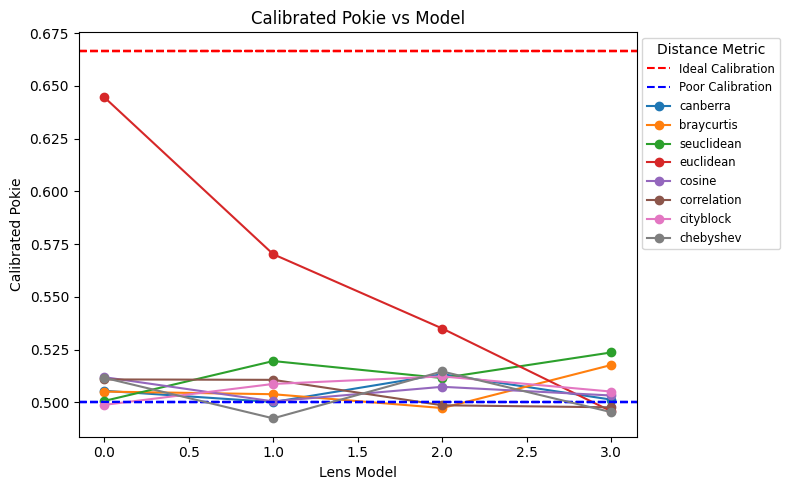

In [14]:
# Load in the data for all the distance metrics
data = {}
results_file = '/Users/sammysharief/Downloads/Pokie/notebook/Distance_Exp/Pokie_Result_Lensed_Images_Curr_Num_Runs_100.txt'
# Read the results file and store the data
with open(results_file, "r") as f:
    for line in f:
        if line.strip():  # Skip empty lines
            parts = line.strip().split('|')
            if len(parts) == 3:
                distance_metric = parts[0].strip()
                noise_level = float(parts[1].strip())
                calibrated_pokie = float(parts[2].strip())
                
                if distance_metric not in data:
                    data[distance_metric] = {}
                data[distance_metric][noise_level] = calibrated_pokie

print(data)
print(data.keys())
plt.figure(figsize=(8, 5))
# Plot the data for each key in data
for distance_metric, noise_data in data.items():
    noise_levels = sorted(noise_data.keys())
    calibrated_values = [noise_data[nl] for nl in noise_levels]

    if distance_metric == 'canberra':
        plt.axhline(y=2/3, color='r', linestyle='--', label='Ideal Calibration')
        plt.axhline(y=1/2, color='b', linestyle='--', label='Poor Calibration')
    else:
        plt.axhline(y=2/3, color='r', linestyle='--')
        plt.axhline(y=1/2, color='b', linestyle='--')
    
    
    plt.plot(noise_levels, calibrated_values, marker='o', label=distance_metric)
    plt.xlabel('Lens Model')
    plt.ylabel('Calibrated Pokie')
    plt.title(f'Calibrated Pokie vs Model')
    
# Put Legend outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small', title='Distance Metric')
plt.tight_layout()
plt.savefig(f'{project_root}/Plots/Different_Distance_Metrics/Pokie_Lensed_Images_Different_Distance_Metrics_Curr_Num_Runs_100.pdf')
plt.show()
    